#  **Theif Detection Using Computer Vision**

### ***Install Required Libraries***

In [35]:
!pip install ultralytics deepface opencv-python matplotlib torch


### ***Import Required Modules***



In [ ]:
import cv2
import time
import numpy as np
from ultralytics import YOLO
from deepface import DeepFace
import matplotlib.pyplot as plt


### ***Import Required Modules***



In [37]:
# Load a more accurate YOLOv8 model
model = YOLO("yolov8s.pt")

# Define reference object
REFERENCE_OBJECT_HEIGHT_CM = 100

#  Harmful objects
HARMFUL_OBJECTS = ["knife", "gun", "weapon"]


###  ***Theif Detection & Analysis Function***

In [72]:
def detect_thief(image_path):
    frame = cv2.imread(image_path)
    if frame is None:
        return {"error": "⚠️ Invalid image file or path!"}

    img_height, img_width, _ = frame.shape

    start_time = time.time()

    # Run YOLO object detection
    results = model(frame, conf=0.5)  # Confidence threshold: 0.5

    thief_detected = False
    detected_objects = []
    harmful_objects_detected = []
    thief_box = None

    # Process YOLO detections
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            label = model.names.get(class_id, "unknown")

            # Ignore low-confidence detections
            if confidence < 0.5:
                continue

            if label == "person":
                thief_detected = True
                thief_box = (x1, y1, x2, y2)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)  # Red Box for Thief
                cv2.putText(frame, "THIEF", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            elif label in HARMFUL_OBJECTS:
                harmful_objects_detected.append(label)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 165, 255), 3)  # Orange Box for Harmful Objects
                cv2.putText(frame, label.upper(), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 165, 255), 2)
            else:
                detected_objects.append(label)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green Box for Normal Objects
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Stop timer and calculate inference time
    inference_time = round(time.time() - start_time, 2)

    # Initialize age & gender
    age, gender = None, None

    # Perform face analysis if a thief is detected
    if thief_detected:
        try:
            face_analysis = DeepFace.analyze(image_path, actions=["age", "gender"], enforce_detection=False)
            if face_analysis and isinstance(face_analysis, list):
                age = face_analysis[0].get("age", None)
                gender = face_analysis[0].get("dominant_gender", "").capitalize()
                age = max(18, min(age, 80)) if age else None  # Ensure age is realistic
        except Exception as e:
            print(f"⚠️ Face analysis error: {e}")

    # Estimate real-world height
    def estimate_real_height(thief_box, img_height, ref_height_cm):
        """Estimate real-world height of the detected person based on bounding box size."""
        if thief_box:
            person_height_pixels = thief_box[3] - thief_box[1]
            scale_factor = ref_height_cm / img_height  # Adjust based on image height
            estimated_height_cm = person_height_pixels * scale_factor * 1.2  # 1.2 for better estimation
            return round(max(140, min(estimated_height_cm, 200)), 1)

        return 175 if gender == "Man" else 160

    # Estimate weight based on height & gender
    def estimate_real_weight(height_cm, gender):
        """Estimate weight based on height using an average BMI formula."""
        if height_cm:
            avg_bmi = 23 if gender == "Man" else 21  # Slightly higher for men
            return round(avg_bmi * ((height_cm / 100) ** 2), 2)
        return None

    # Compute height & weight dynamically
    height_cm = estimate_real_height(thief_box, img_height, REFERENCE_OBJECT_HEIGHT_CM)
    weight_kg = estimate_real_weight(height_cm, gender)

    # Display the image with bounding boxes
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.title("🔴 Thief in Red | 🟩 Objects in Green | 🟧 Harmful Objects in Orange")
    plt.show()


    return {
        "thief_detected": thief_detected,
        "age": age,
        "gender": gender,
        "estimated_height_cm": height_cm,
        "estimated_weight_kg": weight_kg,
        "detected_objects": detected_objects,
        "harmful_objects": harmful_objects_detected,
        "thief_box": thief_box,
        "inference_time": inference_time
    }


### ***Display the Result***

In [46]:
def display(result):
    print("\n" + "=" * 50)
    print("🔍 **THIEF DETECTION REPORT**")
    print("=" * 50)

    if "error" in result:
        print(result["error"])
    else:
        if result["thief_detected"]:
            print(f"👤 **Age:** {result['age']} years" if result['age'] else "👤 **Age:** Unknown")
            print(f"🧑 **Gender:** {result['gender']}" if result['gender'] else "🧑 **Gender:** Unknown")
            print(f"📏 **Estimated Height:** {result['estimated_height_cm']} cm")
            print(f"⚖ **Estimated Weight:** {result['estimated_weight_kg']} kg")
            print(f"📦 **Detected Objects:** {', '.join(result['detected_objects'])}" if result['detected_objects'] else "📦 No additional objects detected.")
            print(f"⚠️ **Harmful Objects:** {', '.join(result['harmful_objects'])}" if result['harmful_objects'] else "⚠️ No harmful objects detected.")
        else:
            print("✅ **No thief detected in the image!**")

        print(f"⏱ **Inference Time:** {result['inference_time']} seconds")
    print("=" * 50)


### ***Theif Example-1***


0: 480x640 1 person, 1 couch, 1 potted plant, 2 books, 467.5ms
Speed: 9.1ms preprocess, 467.5ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


Action: gender: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


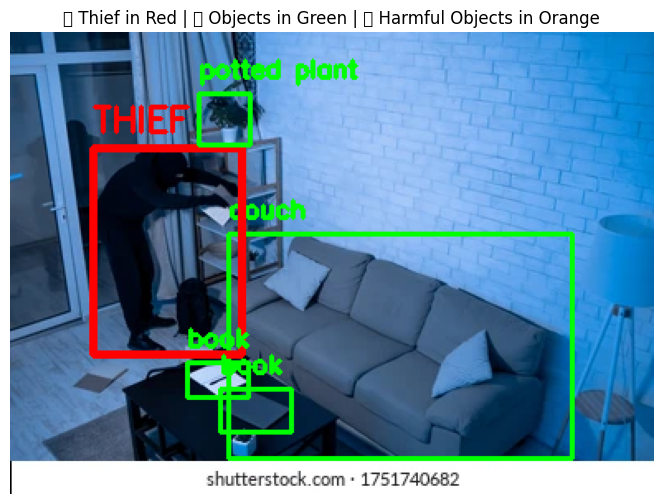


🔍 **THIEF DETECTION REPORT**
👤 **Age:** 36 years
🧑 **Gender:** Man
📏 **Estimated Height:** 140 cm
⚖ **Estimated Weight:** 45.08 kg
📦 **Detected Objects:** couch, book, book, potted plant
⚠️ No harmful objects detected.
⏱ **Inference Time:** 0.49 seconds


In [62]:
image_path = "/content/theif1.png"
result = detect_thief(image_path)
display(result)


### ***Theif Example-2***


0: 480x640 2 persons, 450.4ms
Speed: 4.8ms preprocess, 450.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Action: gender: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


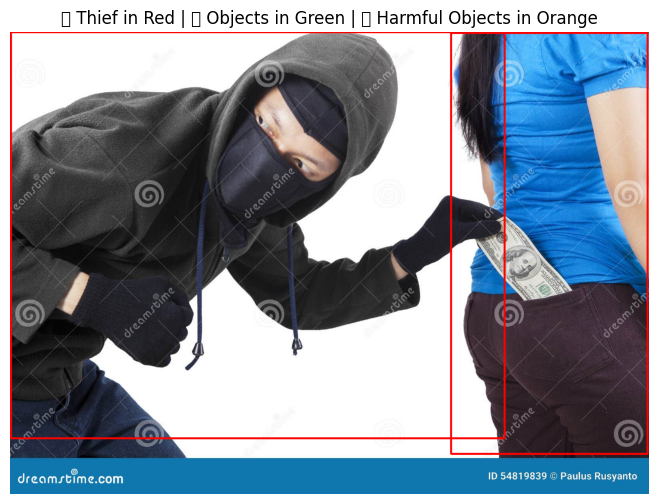


🔍 **THIEF DETECTION REPORT**
👤 **Age:** 35 years
🧑 **Gender:** Man
📏 **Estimated Height:** 179.3 cm
⚖ **Estimated Weight:** 73.94 kg
📦 No additional objects detected.
⚠️ No harmful objects detected.
⏱ **Inference Time:** 0.46 seconds


In [63]:
image_path = "/content/theif2.jpg"
result = detect_thief(image_path)
display(result)

### ***Theif Example-3***


0: 448x640 1 person, 1 couch, 438.2ms
Speed: 4.5ms preprocess, 438.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Action: gender: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


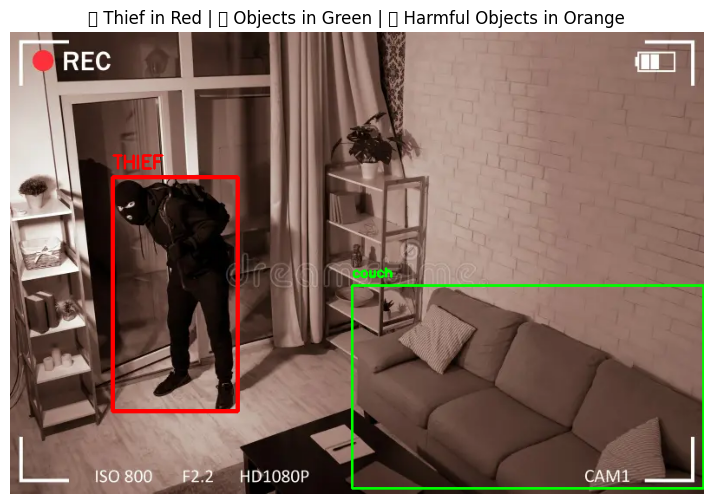


🔍 **THIEF DETECTION REPORT**
👤 **Age:** 29 years
🧑 **Gender:** Man
📏 **Estimated Height:** 140 cm
⚖ **Estimated Weight:** 45.08 kg
📦 **Detected Objects:** couch
⚠️ No harmful objects detected.
⏱ **Inference Time:** 0.45 seconds


In [66]:
image_path = "theif3.png"
result = detect_thief(image_path)
display(result)

### ***Theif Example-4***


0: 480x640 1 person, 2 couchs, 1 potted plant, 1 tv, 459.0ms
Speed: 3.4ms preprocess, 459.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Action: gender: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


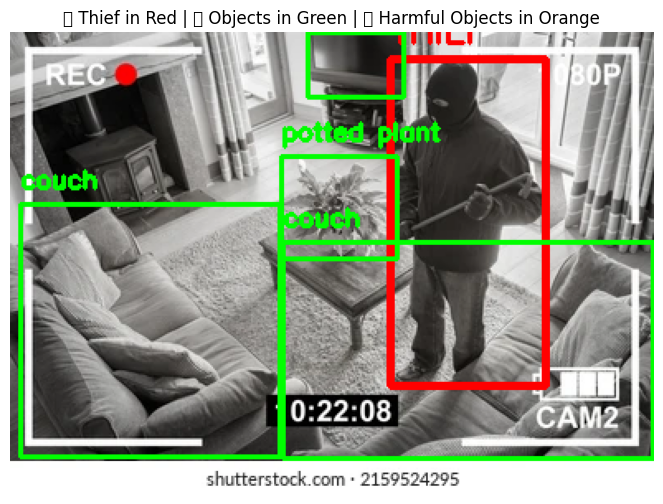


🔍 **THIEF DETECTION REPORT**
👤 **Age:** 34 years
🧑 **Gender:** Man
📏 **Estimated Height:** 144.3 cm
⚖ **Estimated Weight:** 47.89 kg
📦 **Detected Objects:** potted plant, couch, couch, tv
⚠️ No harmful objects detected.
⏱ **Inference Time:** 0.47 seconds


In [71]:
image_path = "/content/theif4.png"
result = detect_thief(image_path)
display(result)

### ***Theif Example-5***


0: 480x640 1 person, 1 chair, 1 couch, 1192.2ms
Speed: 7.8ms preprocess, 1192.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Action: gender: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


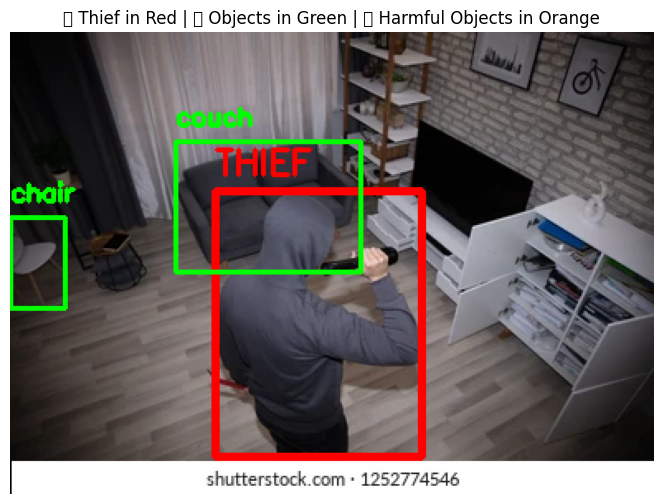


🔍 **THIEF DETECTION REPORT**
👤 **Age:** 30 years
🧑 **Gender:** Man
📏 **Estimated Height:** 140 cm
⚖ **Estimated Weight:** 45.08 kg
📦 **Detected Objects:** couch, chair
⚠️ No harmful objects detected.
⏱ **Inference Time:** 1.22 seconds


In [74]:
image_path = "/content/theif5.jpg"
result = detect_thief(image_path)
display(result)